In [8]:
library(keras)
library(data.table)

In [9]:
q <- 5000 # Total number of samples
l <- 200 # Vector length of each sample
xfull <- 1:l
X <- data.table(n = integer(q*l),y = numeric(q*l),truth = integer(q*l),loc = integer(q*l))

#i = 2
for (i in 1:q) {
    
    rstart <- (i - 1)*l + 1
    rend <- i*l
    
    if (sample(c(0,1),1) == 1) {
        
        cross <- sample(seq(from = 0.3*l,to = 0.7*l,by = 1),1) + round(rnorm(1,sd = 20),digits = 0)
        while ((cross < 10) || (cross > (l - 10))) {
            cross <- sample(seq(from = 0.3*l,to = 0.7*l,by = 1),1) + round(rnorm(1,sd = 30),digits = 0)
        }
        x1 <- 1:cross
        x2 <- 1:(l - cross)
        
        y1 <- rnorm(1,mean = -0.1,sd = 0.05)
        while (y1 > 0) {
            y1 <- rnorm(1,mean = -0.1,sd = 0.05)
        }
    
        y2 <- rnorm(1,mean = -0.7,sd = 0.5)
        while (y2 > (y1 - 0.05)) {
            y2 <- rnorm(1,mean = -0.7,sd = 0.5)
        }
        
        y1 <- y1*x1
        y2 <- y2*x2 - abs(min(y1))
    
        Y <- c(y1,y2)
        n <- rnorm(length(Y),mean = 1,sd = 0.03)
        Y <- Y*n + rnorm(length(Y),sd = 2)
        
        #Y <- jitter(Y,factor = n) #rnorm(length(Y),mean = mean(Y)*n)
        #plot(Y)
        
        X[(rstart:rend),n := i]
        X[(rstart:rend),y := Y]
        X[(rstart:rend),truth := 1L]
        X[(rstart:rend),loc := cross]

        #Sys.sleep(1)
    } else {
        
        y1 <- rnorm(1,mean = -0.3,sd = 0.3)
        while (y1 > 0) {
            y1 <- rnorm(1,mean = -0.1,sd = 0.05)
        }
        
        Y <- y1*xfull
        n <- rnorm(length(Y),mean = 1,sd = 0.03)
        Y <- Y*n + rnorm(length(Y),sd = 2)
        
        #plot(Y)
        #Sys.sleep(1)
        
        X[(rstart:rend),n := i]
        X[(rstart:rend),y := Y]
        X[(rstart:rend),truth := 0L]
        X[(rstart:rend),loc := 0L]
        
    }
    
}

print(nrow(X))

[1] 1000000


In [10]:
# Get train / test split
train_index <- sample(unique(X$n),round(0.8*q,digits = 0),replace = FALSE)
test_index <- setdiff(unique(X$n),train_index)

x_train <- X[(n %in% train_index),y]
x_test <- X[(n %in% test_index),y]

y_train <- X[(n %in% train_index),head(.SD,1),by = n]$truth
y_test <- X[(n %in% test_index),head(.SD,1),by = n]$truth

# Reshape for scaling
x_train <- array(x_train,dim = c(l,length(train_index)))
x_test <- array(x_test,dim = c(l,length(test_index)))

x_train_scale <- scale(x_train)
x_test_scale <- scale(x_test)

x_train_scale <- t(x_train_scale)
x_test_scale <- t(x_test_scale)

x_train_scale <- array(x_train_scale,dim = c(length(train_index),l,1))
x_test_scale <- array(x_test_scale,dim = c(length(test_index),l,1))

In [11]:
dim(x_train_scale)

[1] 4000  200    1

[1] 3014
[1] 974


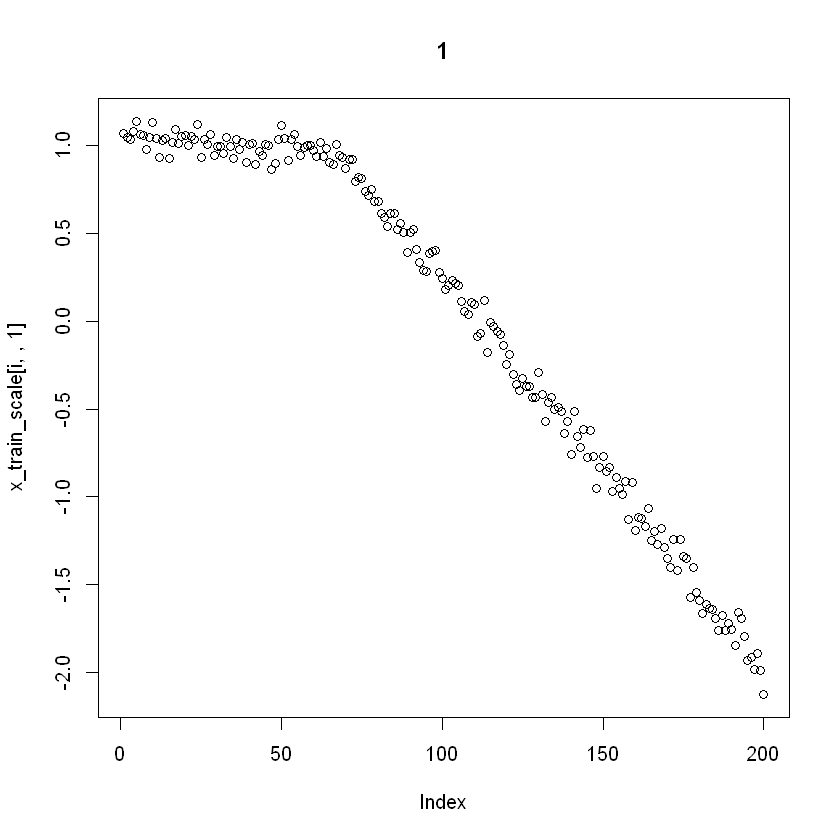

[1] 3271


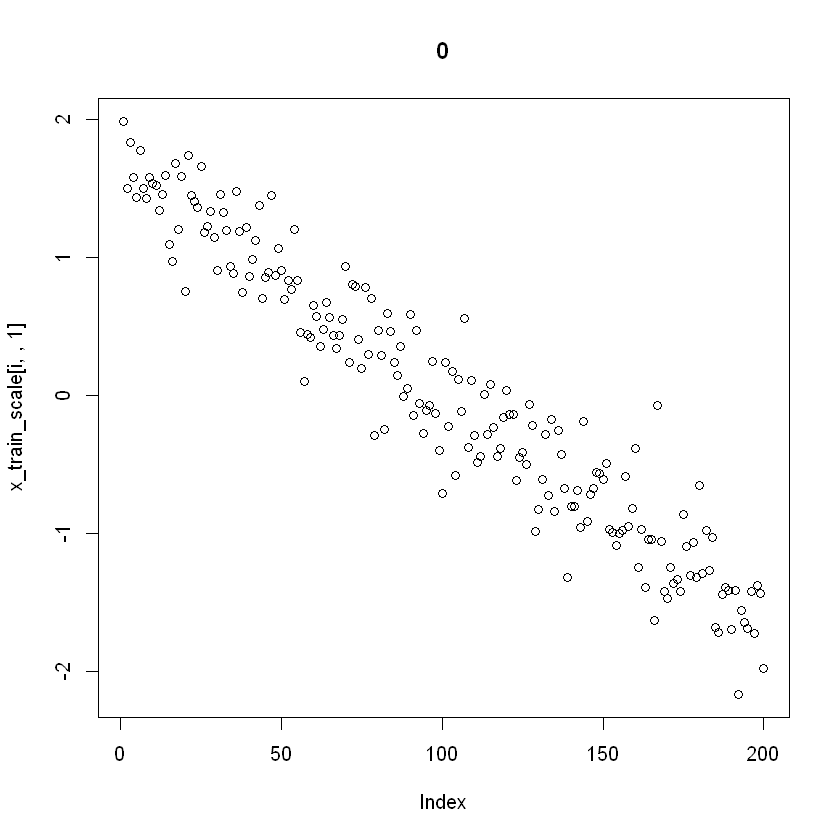

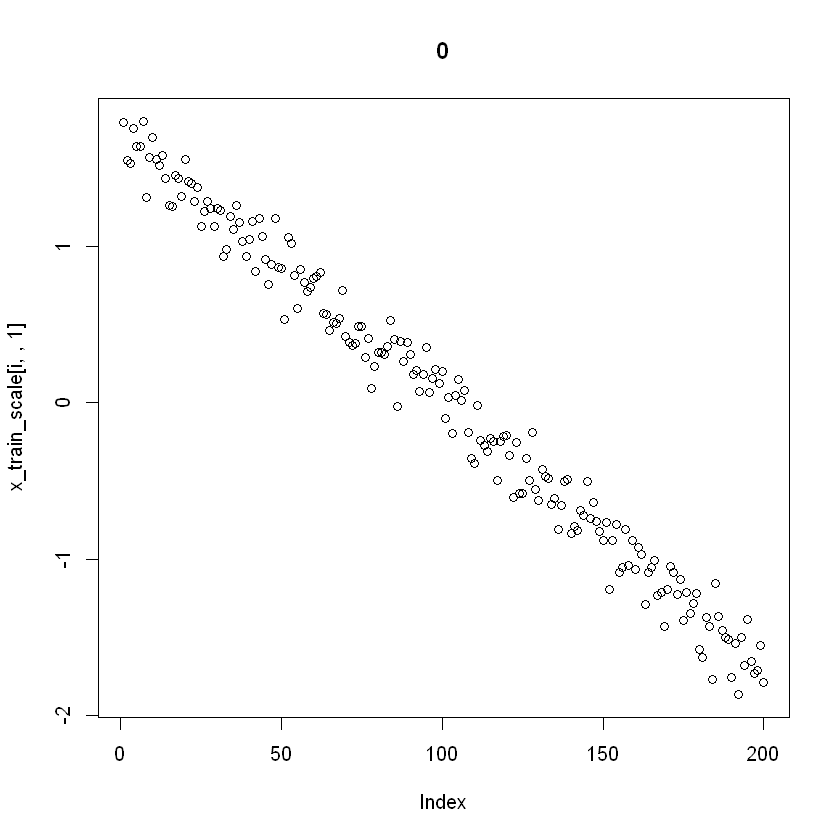

In [19]:
for (i in sample(1:q,3)) {
    print(i)
    plot(x_train_scale[i,,1],main = y_train[i])
    Sys.sleep(1)
}

In [20]:
classification_model <- keras_model_sequential() %>% 
    layer_conv_1d(filters = 32, kernel_size = 5, activation = "relu",input_shape = c(l,1),strides = 10L) %>%
    layer_conv_1d(filters = 32, kernel_size = 5,strides = 1L) %>%
    layer_max_pooling_1d() %>%
    layer_conv_1d(filters = 32, kernel_size = 5,strides = 1L) %>%
    layer_dropout(0.5) %>%
    layer_flatten() %>%
    layer_dense(units = 2, activation = "softmax")


classification_model %>% compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = 'accuracy')

classification_model %>% summary()

classification_model %>% fit(x_train_scale, y_train, epochs = 100, verbose = TRUE)

classification_model %>% evaluate(x_test_scale, y_test, verbose = TRUE)


Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv1d_2 (Conv1D)                   (None, 20, 32)                  192         
________________________________________________________________________________
conv1d_1 (Conv1D)                   (None, 16, 32)                  5152        
________________________________________________________________________________
max_pooling1d (MaxPooling1D)        (None, 8, 32)                   0           
________________________________________________________________________________
conv1d (Conv1D)                     (None, 4, 32)                   5152        
________________________________________________________________________________
dropout (Dropout)                   (None, 4, 32)                   0           
________________________________________________________________________________
flatten 

$loss
[1] 0.1092247

$accuracy
[1] 0.987

In [26]:
regr_index <- X[truth == 1,unique(n)]
train_index_regr <- sample(regr_index,round(0.8*length(regr_index),digits = 0),replace = FALSE)
test_index_regr <- setdiff(regr_index,train_index_regr)

x_train_regr <- X[(n %in% train_index_regr),y]
x_test_regr <- X[(n %in% test_index_regr),y]

y_train_regr <- X[(n %in% train_index_regr),head(.SD,1),by = n]$loc/l
y_test_regr <- X[(n %in% test_index_regr),head(.SD,1),by = n]$loc/l

# Reshape for scaling
x_train_regr <- array(x_train_regr,dim = c(l,length(train_index_regr)))
x_test_regr <- array(x_test_regr,dim = c(l,length(test_index_regr)))

x_test_scale_regr <- scale(x_test_regr)
x_train_scale_regr <- scale(x_train_regr)

In [27]:
x_train_scale_regr <- t(x_train_scale_regr)
x_test_scale_regr <- t(x_test_scale_regr)

x_train_scale_regr <- array(x_train_scale_regr,dim = c(length(train_index_regr),l,1))
x_test_scale_regr <- array(x_test_scale_regr,dim = c(length(test_index_regr),l,1))

In [28]:
regression_model <- keras_model_sequential() %>% 
    layer_conv_1d(filters = 32, kernel_size = 5, activation = "relu",input_shape = c(l,1),strides = 5L) %>%
    layer_dropout(0.5) %>%
    layer_conv_1d(filters = 32, kernel_size = 5,strides = 1L) %>%
    layer_dropout(0.5) %>%
    layer_max_pooling_1d() %>%
    layer_conv_1d(filters = 32, kernel_size = 5,strides = 1L) %>%
    layer_dense(units = 16) %>%
    layer_flatten() %>%
    layer_dense(units = 1, activation = "linear")

regression_model %>% compile(
        loss = "mse",
        optimizer = "adam",
        metrics = "mean_absolute_error")



regression_model %>% summary()

regression_model %>% fit(x_train_scale_regr, y_train_regr, epochs = 100, verbose = TRUE)

regression_model %>% evaluate(x_test_scale_regr, y_test_regr, verbose = TRUE)

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv1d_5 (Conv1D)                   (None, 40, 32)                  192         
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 40, 32)                  0           
________________________________________________________________________________
conv1d_4 (Conv1D)                   (None, 36, 32)                  5152        
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 36, 32)                  0           
________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)      (None, 18, 32)                  0           
________________________________________________________________________________
conv1d

$loss
[1] 0.009851095

$mean_absolute_error
[1] 0.08556893

In [29]:
predict_regr <- regression_model %>% predict(x_test_scale_regr)

predict_regr <- predict_regr*l

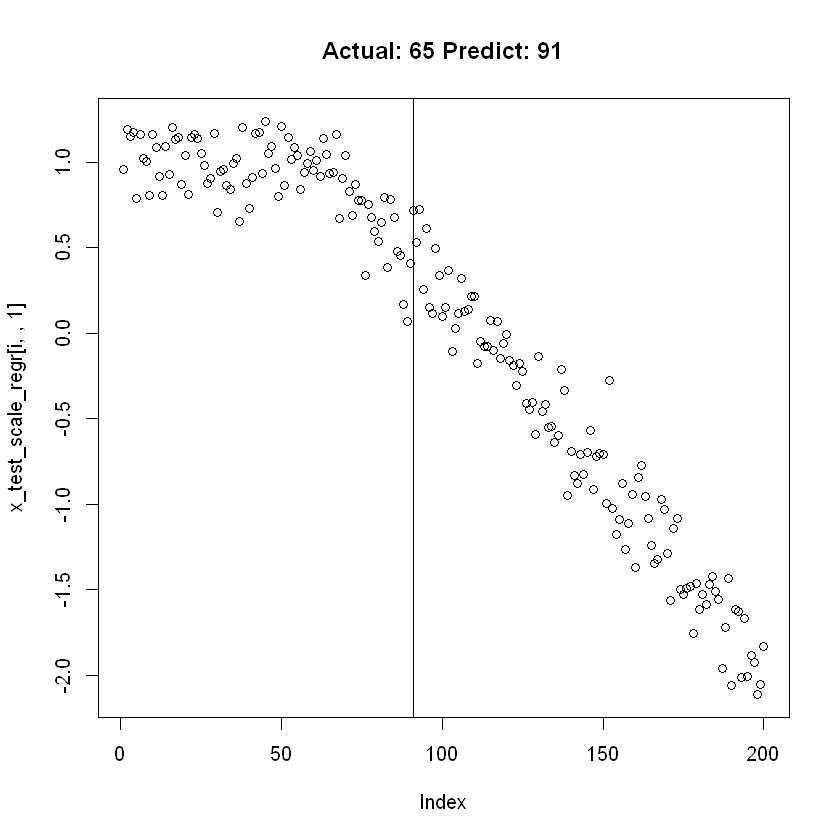

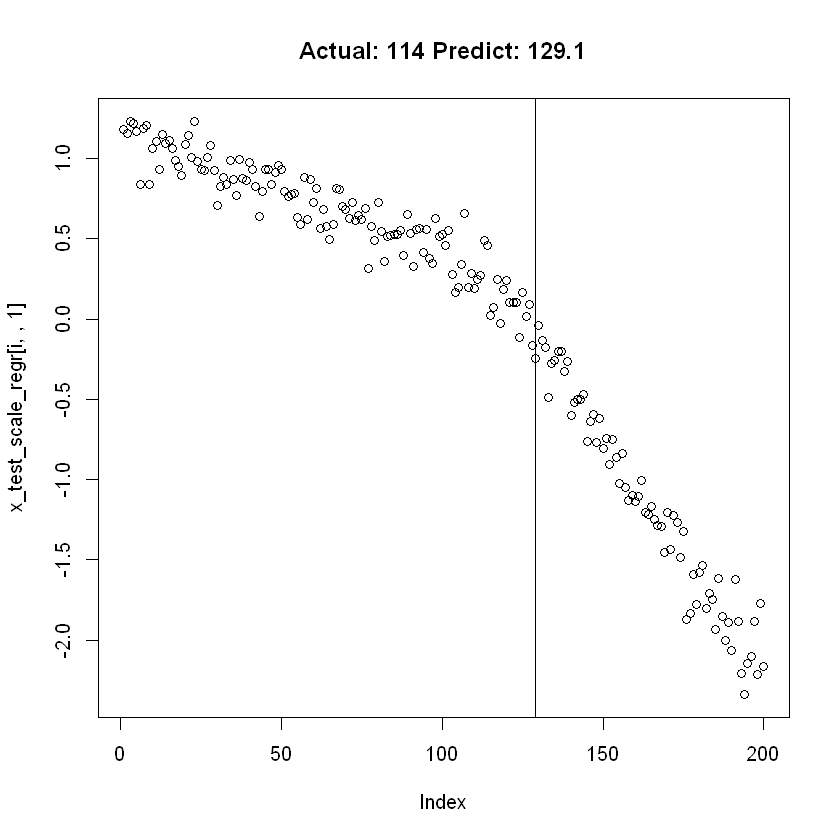

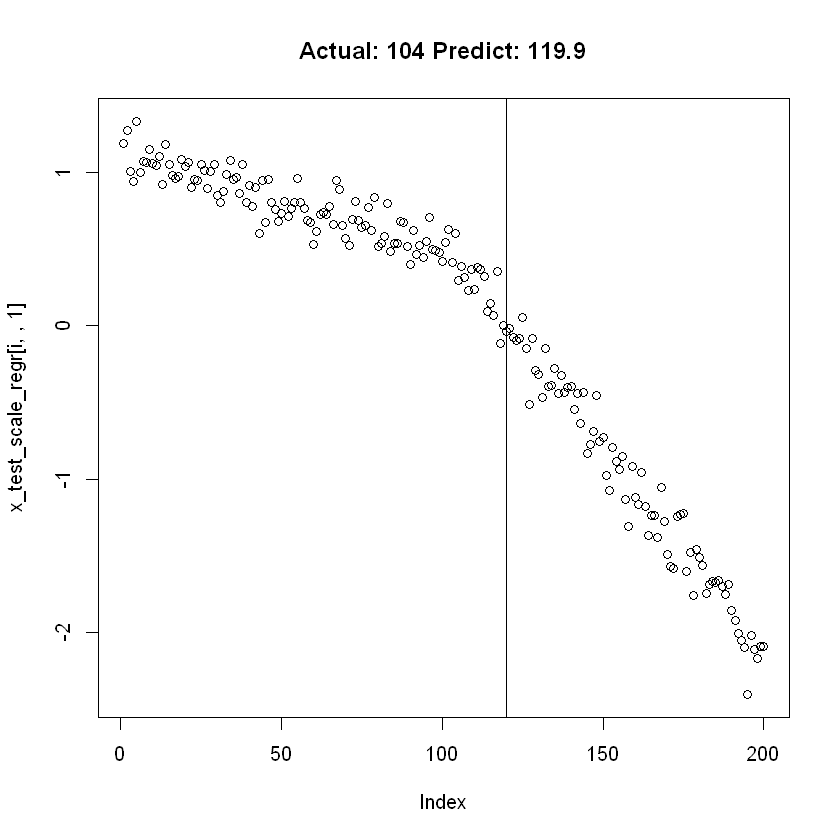

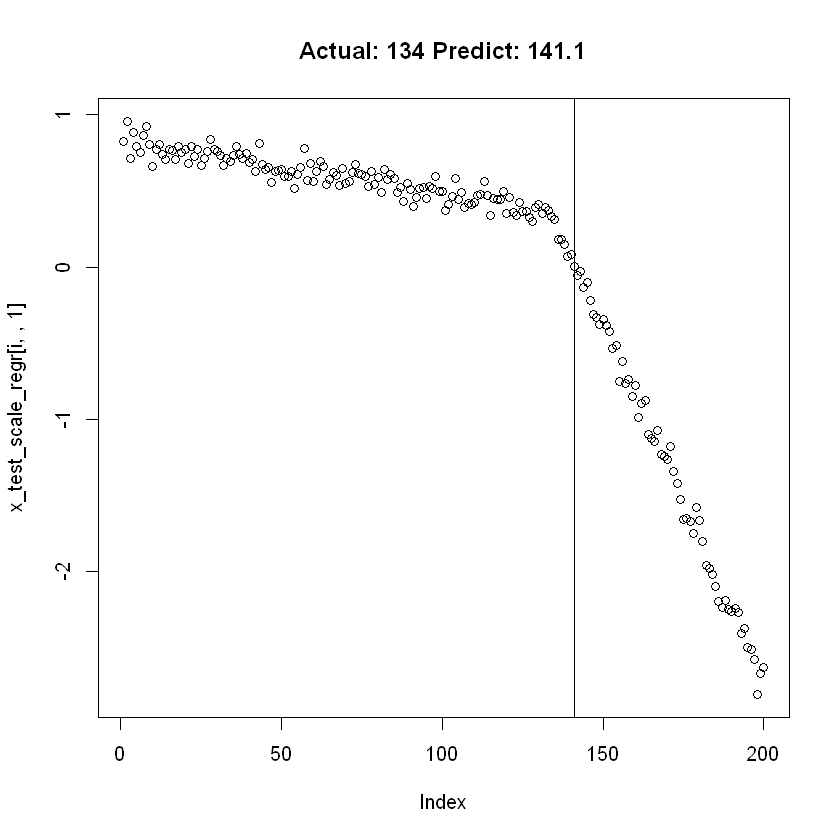

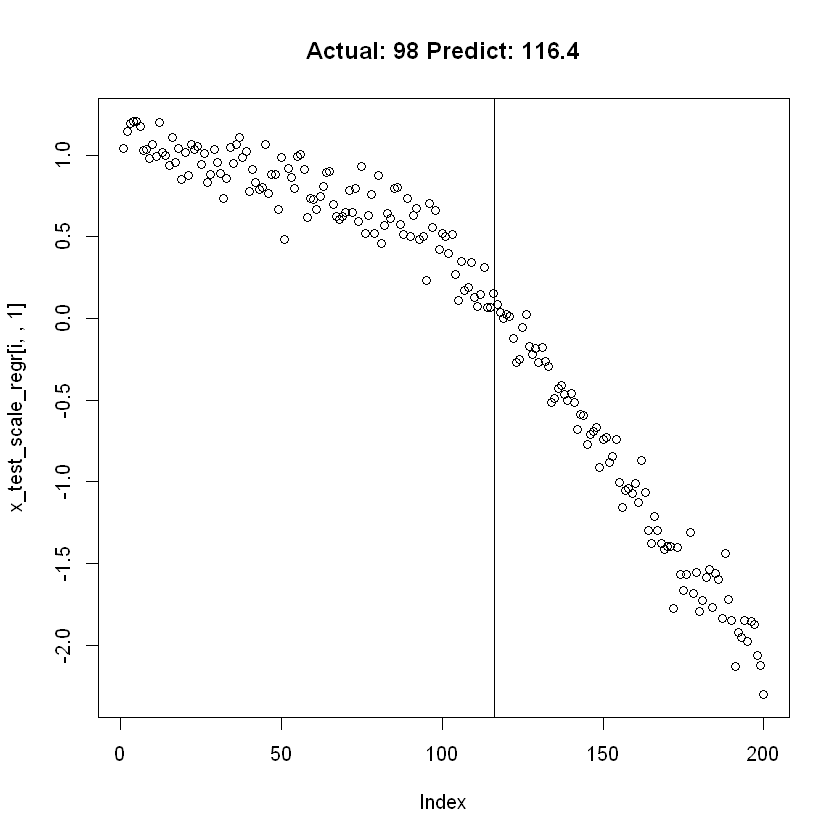

In [31]:
q <- sample(1:nrow(x_test_scale_regr),5)
for (i in q) {
    plot(x_test_scale_regr[i,,1],main = paste0("Actual: ",l*y_test_regr[i]," Predict: ",round(predict_regr[i],digits = 1)))
    abline(v = predict_regr[i])
}